In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
% cd /content/drive/MyDrive/

In [ ]:
! pip install opencv-contrib-python==4.5.4.60
! sudo apt-get install libzbar0
! pip install pyzbar

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from pyzbar.pyzbar import decode, ZBarSymbol
from imutils.object_detection import non_max_suppression

## Solution

Решение состоит из следующих этапов:


*   С помощью pyzbar или OpenCV детекчу QR-code
*   Беру шаблон finder pattern'a и пытаюсь найти scale, при котором у уменьшенного QR-code наибольшая корреляция с заданным шаблоном (метод findTemplate не инвариатен к размеру)
*   После этого уменьшаю изображение с найденным выше scale и нахожу все относительно релеватные к заданному шаблону кусочки, далее отсекаю ненужные по заданному threshold'у корреляции и с помощью non_max_suppression оставляю только один bounding box на finder pattern


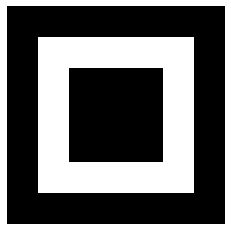

In [5]:
FINDER_PATTERN_TEMPLATE = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 255, 255, 255, 0],
    [0, 255, 0, 0, 0, 255, 0],
    [0, 255, 0, 0, 0, 255, 0],
    [0, 255, 0, 0, 0, 255, 0],
    [0, 255, 255, 255, 255, 255, 0],
    [0, 0, 0, 0, 0, 0, 0],
]).astype('uint8')

plt.imshow(FINDER_PATTERN_TEMPLATE, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
def get_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 11)    
    return img

In [7]:
def get_qr(img):
    qr = []
    inv_M = []
    pyzbar_decode = decode(img, symbols=[ZBarSymbol.QRCODE])
    if len(pyzbar_decode) > 0:
        polygon = pyzbar_decode[0].polygon
        h, w = pyzbar_decode[0].rect[2:]
        points = np.array(list(map(lambda p: [p.x, p.y], polygon))).astype('float32')
        points = np.roll(points, 1, 0)
        dist = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype='float32')
        M = cv2.getPerspectiveTransform(points, dist)
        inv_M = cv2.getPerspectiveTransform(dist, points)
        qr = cv2.warpPerspective(img, M, (w, h))
    else:
        qrCodeDetector = cv2.QRCodeDetector()
        decodedText, points, _ = qrCodeDetector.detectAndDecode(img)
        if points is not None:
            points = points[0]
            w = int(max(points[:, 0]) - min(points[:, 0]))
            h = int(max(points[:, 1]) - min(points[:, 1]))
            dist = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype='float32')
            M = cv2.getPerspectiveTransform(points, dist)
            inv_M = cv2.getPerspectiveTransform(dist, points)
            qr = cv2.warpPerspective(img, M, (w, h))
    return qr, inv_M

In [8]:
def get_scale(qr, template):
    max_val = -1
    max_scale = 1
    h, w = qr.shape
    th, tw = template.shape

    for scale in np.linspace(1e-8, 80. / h, 30)[::-1]:
        new_w, new_h = int(w * scale), int(h * scale)
        if new_w < tw or new_h < th:
            break

        resized = cv2.resize(qr, (new_w, new_h), cv2.INTER_CUBIC)
        _, resized = cv2.threshold(resized, 200, 255, cv2.THRESH_BINARY)
        res = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
        (_, val, _, _) = cv2.minMaxLoc(res)
        if max_val < val:
            max_val = val
            max_scale = scale
    return max_scale

In [9]:
def get_rects(qr, template, scale, threshold = 0.6):
    th, tw = template.shape
    h, w = qr.shape
    new_w, new_h = int(w * scale), int(h * scale)
    inv_scale = 1 / scale

    resized = cv2.resize(qr, (new_w, new_h), cv2.INTER_CUBIC)
    _, resized = cv2.threshold(resized, 200, 255, cv2.THRESH_BINARY)
    res = cv2.matchTemplate(resized, template, cv2.TM_CCOEFF_NORMED)
    (yCoords, xCoords) = np.where(res >= threshold)

    rects = []
    for (x, y) in zip(xCoords, yCoords):
        rects.append((int(x * inv_scale), int(y * inv_scale), int((x + tw) * inv_scale), int((y + th) * inv_scale)))

    pick = non_max_suppression(np.array(rects))
    return pick

In [10]:
test1_names = os.listdir('TestSet1')
test1_names = list(map(lambda x: os.path.join('TestSet1', x), test1_names))
test2_names = os.listdir('TestSet2')
test2_names = list(map(lambda x: os.path.join('TestSet2', x), test2_names))

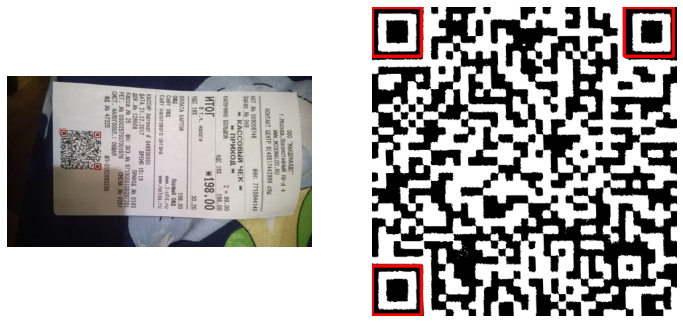

In [11]:
path = test2_names[15]
img = get_img(path)
qr, M = get_qr(img)

if len(qr) > 0:
    scale = get_scale(qr, FINDER_PATTERN_TEMPLATE)
    rects = get_rects(qr, FINDER_PATTERN_TEMPLATE, scale)
    if rects is not None and len(rects) > 0:
        rgb_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        rgb_qr = cv2.cvtColor(qr, cv2.COLOR_GRAY2RGB)
        for (startX, startY, endX, endY) in rects:
            start_arr = list(map(lambda x: max(0, int(x)), M @ np.array((startX, startY, 1))))
            end_arr = list(map(lambda x: max(0, int(x)), M @ np.array((endX, endY, 1))))
            cv2.rectangle(rgb_img, tuple(start_arr[:2]), tuple(end_arr[:2]), (255, 0, 0), 3)
            cv2.rectangle(rgb_qr, (startX, startY), (endX, endY), (255, 0, 0), 3)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 12))
        ax1.imshow(rgb_img)
        ax1.axis('off')
        ax2.imshow(rgb_qr)
        ax2.axis('off')
        plt.show()

## Results

In [12]:
good = 0
start_time = time()
for i in tqdm(range(len(test1_names))):
    img = get_img(test1_names[i])
    qr, _ = get_qr(img)

    if len(qr) > 0:
        scale = get_scale(qr, FINDER_PATTERN_TEMPLATE)
        rects = get_rects(qr, FINDER_PATTERN_TEMPLATE, scale)
        if rects is not None and len(rects) > 0:
            if len(rects) == 3:
                good += 1
end_time = time()

print('Precision по TestSet1: ',  good / len(test1_names))
print('Среднее время выполнения:', (end_time - start_time) / len(test1_names))

  0%|          | 0/47 [00:00<?, ?it/s]

Precision по TestSet1:  0.9148936170212766
Среднее время выполнения: 1.2762411756718413


In [13]:
good = 0
start_time = time()
for i in tqdm(range(len(test2_names))):
    img = get_img(test2_names[i])
    qr, _ = get_qr(img)

    if len(qr) > 0:
        scale = get_scale(qr, FINDER_PATTERN_TEMPLATE)
        rects = get_rects(qr, FINDER_PATTERN_TEMPLATE, scale)
        if rects is not None and len(rects) > 0:
            if len(rects) == 3:
                good += 1
end_time = time()

print('Precision по TestSet2: ',  good / len(test2_names))
print('Среднее время выполнения:', (end_time - start_time) / len(test2_names))

  0%|          | 0/48 [00:00<?, ?it/s]

Precision по TestSet2:  0.7708333333333334
Среднее время выполнения: 1.3216404219468434


Если QR-code распознается, то мануально было обнаружено, что всегда разпознается именно 3 нужных finder-pattern'a. \
Поэтому можно считать, что recall -- 1. \
Однако следует отметить, что bounding box определяется с небольшой погрешностью, иногда заходя чуть-чуть за рамки finder-pattern'a.